# Group-based Classification Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [4]:
from pycaret.classification import *

In [5]:
import functions as f

# Nanotubes classification model

In [6]:
model_name = "nanotube"
group_name = "nanotubes"
seed = 123

### Load the data and filter instances

In [7]:
data_train_df = pd.read_csv("output/datasets/universal/data_classification_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_classification_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [8]:
data_df.shape

(11315, 20)

In [9]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [10]:
data_group_df.shape

(675, 20)

In [11]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
14,Nanotubes,None,68.0,NaN,NaN,NaN,NaN,0.00,96.0,HMM,Human,Blood,Monocyte/Macrophage,Adult,Normal,NaN,Live/Dead,toluylene red,nanotubes,NonToxic
33,MWCNT,None,74.0,NaN,NaN,22.0,NaN,190.00,4.0,BEAS_2B,Human,Lung,Epithelial,Adult,Normal,NaN,Trypan_Blue,Trypan_Blue,nanotubes,NonToxic
56,Nanotubes,metal catalyst residues,1.3,NaN,NaN,NaN,NaN,32.08,48.0,A549,Human,Lung,Epithelial,Adult,cancer,male,LDH,LDHrelease,nanotubes,NonToxic
66,MWCNT,None,17.4,NaN,-18.9,NaN,Needle,4.00,24.0,HUVEC,Human,Umbilical,Endothelial,fetus,Normal,NaN,NR,toluylene red,nanotubes,NonToxic
67,MWCNT,None,5.0,NaN,NaN,NaN,Needle,50.00,24.0,THP_1,Human,Blood,monocyte,neonate,cancer,male,WST-1,TetrazoliumSalt,nanotubes,Toxic


### Create training set and test set

In [12]:
splitter = setup(data = data_group_df, target = 'viability_class',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = seed,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,"NonToxic: 0, Toxic: 1"
4,Original Data,"(675, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,13
8,Transformed Train Set,"(540, 19)"
9,Transformed Test Set,"(135, 19)"


In [13]:
data_group_train_df = get_config(variable="X_train").copy()
data_group_train_df['viability_class'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
data_group_test_df['viability_class'] = get_config(variable="y_test").copy()

In [14]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(540, 20)
(135, 20)


In [15]:
print(data_group_train_df['viability_class'].value_counts())
print(data_group_test_df['viability_class'].value_counts())

0    374
1    166
Name: viability_class, dtype: int64
0    93
1    42
Name: viability_class, dtype: int64


### Save cleaned datasets

In [16]:
data_group_train_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_train_df.csv', encoding='utf-8', index=False)

In [17]:
data_group_test_df.to_csv('output/datasets/'+model_name+'/data_classification_'+model_name+'_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [18]:
sc_ignore_features = ['nanomaterial_group', 'Coating', 'Cell_name']
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'iterative'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = True

### Data Preprcoessing

In [19]:
stup = setup(data = data_group_train_df, target = 'viability_class', 
              
        test_data = data_group_test_df,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        categorical_imputation = "constant", #default: constant
        iterative_imputation_iters = 5, #default: 5
        numeric_iterative_imputer = "lightgbm",
        categorical_iterative_imputer = "lightgbm",

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        high_cardinality_method = "frequency", #default: frequency
        handle_unknown_categorical = True, #default
        unknown_categorical_method = "least_frequent", #default

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        outliers_threshold = 0.05, #default

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        fix_imbalance = True,
        #fix_imbalance_method = SMOTE, # default
        
        # don't change the following
        session_id = seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = model_name)

set_config('seed', seed)

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(540, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(512, 43)
(512,)


In [21]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(540, 43)
(540,)


In [22]:
set_config('X_train', get_config(variable="X").copy()) 
set_config('y_train', get_config(variable="y").copy()) 

In [23]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(540, 43)
(540,)


In [24]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 43)
(135,)


In [25]:
#load_config('output/models/universal_regression_rf.cfg')

In [26]:
data_group_train_transformed_df = get_config(variable="X").copy()
data_group_train_transformed_df['viability_class'] = get_config(variable="y").copy()

In [27]:
data_group_test_transformed_df = get_config(variable="X_test").copy()
data_group_test_transformed_df['viability_class'] = get_config(variable="y_test").copy()

In [28]:
data_group_train_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_train_transformed_df.csv', encoding='utf-8', index=False)
data_group_test_transformed_df.to_csv('output/datasets/'+model_name+'/transformed/data_classification_'+model_name+'_test_transformed_df.csv', encoding='utf-8', index=False)

### Model Comparison

In [29]:
top_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9222,0.9614,0.8805,0.8756,0.8733,0.8176,0.8220,0.0790
catboost,CatBoost Classifier,0.9185,0.9661,0.8805,0.8669,0.8692,0.8104,0.8146,2.1230
rf,Random Forest Classifier,0.9167,0.9544,0.8562,0.8789,0.8633,0.8037,0.8076,0.0910
lightgbm,Light Gradient Boosting Machine,0.9130,0.9634,0.8684,0.8633,0.8590,0.7967,0.8033,0.0210
et,Extra Trees Classifier,0.9074,0.9500,0.8375,0.8663,0.8456,0.7800,0.7856,0.0760
gbc,Gradient Boosting Classifier,0.9037,0.9601,0.8507,0.8480,0.8440,0.7749,0.7798,0.0260
ada,Ada Boost Classifier,0.8944,0.9386,0.8493,0.8208,0.8329,0.7561,0.7581,0.0210
knn,K Neighbors Classifier,0.8870,0.9371,0.8801,0.7885,0.8281,0.7451,0.7514,0.1780
dt,Decision Tree Classifier,0.8704,0.8556,0.8085,0.7948,0.7949,0.7010,0.7069,0.0050
lr,Logistic Regression,0.8481,0.9390,0.8430,0.7148,0.7720,0.6595,0.6663,0.3950


In [30]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_comparison_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [31]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 43)
(135,)


In [32]:
print(results_df.iloc[0,0])

xgboost


### 10-fold cross-validation of the best performing model

In [33]:
model = create_model(results_df.iloc[0,0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.9260,0.8750,0.7778,0.8235,0.7429,0.7456
1,0.9259,0.9482,0.8750,0.8750,0.8750,0.8224,0.8224
2,0.9444,0.9868,0.9375,0.8824,0.9091,0.8691,0.8700
3,0.9074,0.9852,1.0000,0.7619,0.8649,0.7964,0.8134
4,0.9259,0.9507,0.8824,0.8824,0.8824,0.8283,0.8283
5,0.9074,0.9515,0.8235,0.8750,0.8485,0.7819,0.7827
6,0.9074,0.9746,0.7059,1.0000,0.8276,0.7668,0.7886
7,0.9074,0.9181,0.8235,0.8750,0.8485,0.7819,0.7827
8,0.9815,0.9936,1.0000,0.9444,0.9714,0.9577,0.9586


In [34]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_cross_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [35]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 43)
(135,)


### Finalize the model

In [36]:
final_model = finalize_model(model)

In [37]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(135, 43)
(135,)


### Test the model on the test set

In [38]:
pred_test_set = predict_model(final_model, data=data_group_test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9111,0.9595,0.8571,0.8571,0.8571,0.7926,0.7926


In [39]:
results_df = pull()

results_df = results_df.reset_index(level=0)

results_df.to_csv('output/models_results/'+model_name+'/' + model_name + '_classification_model_test_set_validation_results.tsv', 
                index=False, encoding="utf-8", sep="\t")

In [40]:
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9111,0.9595,0.8571,0.8571,0.8571,0.7926,0.7926


,core_size_nm,Surf_charge_mV,Surface_area_m2_g,Dose_microg_mL,Duration_h,NP_type_MWCNT,NP_type_Nanotubes,NP_type_SWCNT,Cell_species_Hamster,Cell_species_Human,...,Assay_MTS,Assay_MTT,Assay_NR,Assay_WST-1,Test_indicator_TetrazoliumSalt,Test_indicator_Trypan_Blue,Test_indicator_toluylene red,viability_class,Label,Score
0,-0.385876,-0.593241,0.995894,0.452526,-0.582314,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0.6291
1,-0.414434,-0.462877,0.350723,-0.724159,1.283855,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0.9215
2,-0.376357,-0.286822,-0.966017,-0.277384,0.350771,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.9995
3,-0.103472,0.037860,-1.555832,-0.136111,-0.582314,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9990
4,-0.477896,-0.081449,0.277404,0.104995,-0.582314,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-0.452511,-0.411193,0.228545,-0.136111,-0.582314,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0.9988
131,-0.328126,-1.058460,0.602772,-0.136111,-0.582314,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0.9978
132,-0.281165,-0.068567,-0.572393,-0.724748,-0.582314,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9976
133,-0.452511,-0.383917,0.276217,1.629801,-0.582314,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0.9997


### Inspect model plots

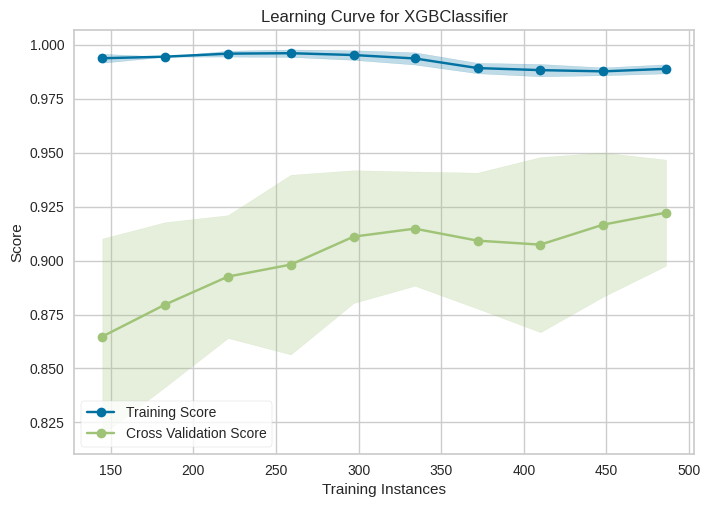

In [41]:
plot_model(final_model, plot = 'learning')

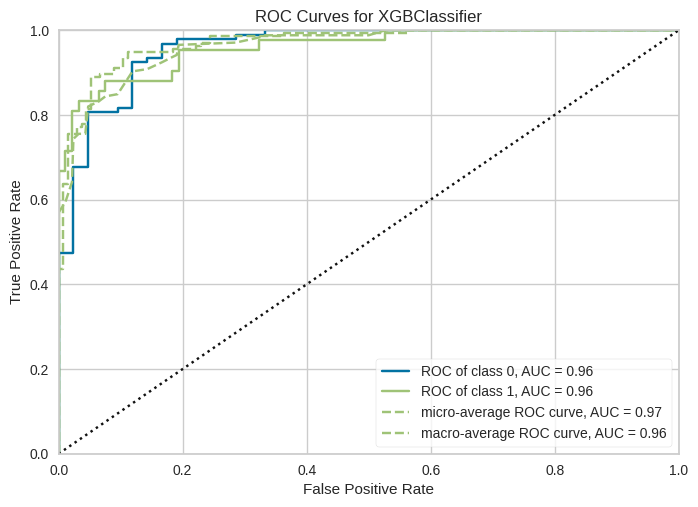

In [42]:
plot_model(final_model, plot = 'auc')

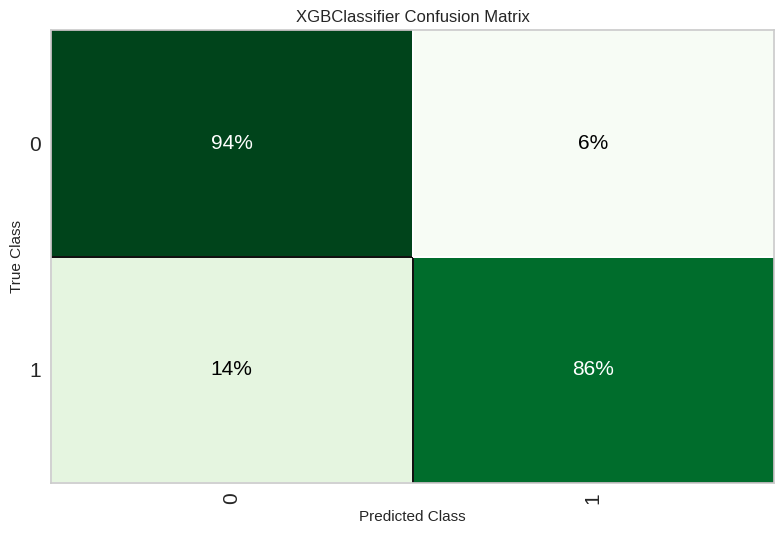

In [43]:
plot_model(final_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

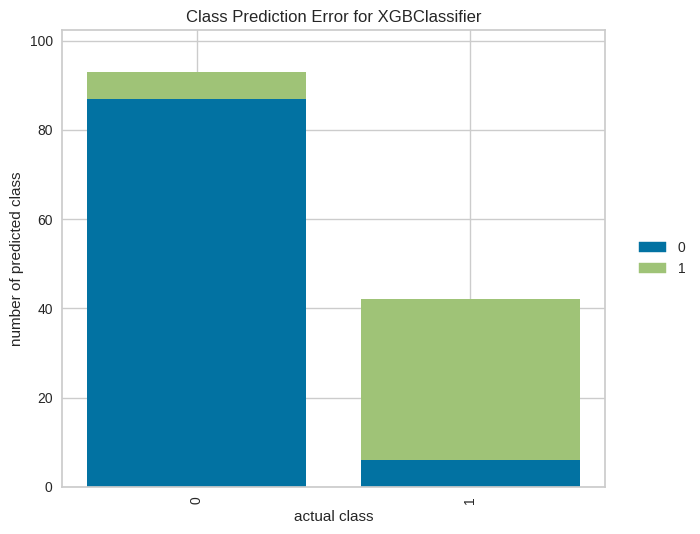

In [44]:
plot_model(final_model, plot = 'error')

### Feature importance plot

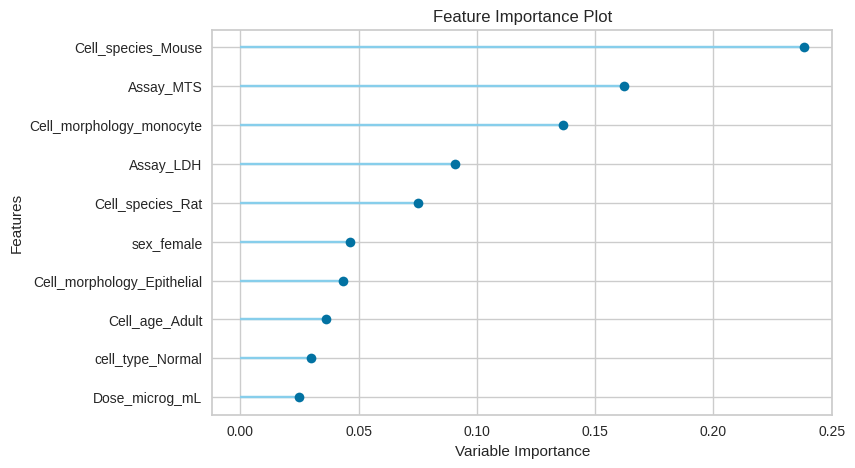

In [45]:
plot_model(final_model, plot = 'feature')

### Save the model to file

In [46]:
save_config('output/models/'+model_name+'_classification_config.cfg')

In [47]:
save_model(final_model, 'output/models/'+model_name+'_classification_model.mdl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['nanomaterial_group',
                                                        'Coating', 'Cell_name'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='viability_class',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=LGBMClassifier(boo...
                                gamma=0, gpu_id=-1, grow_policy='depthwise',
                                importance_type=None, interaction_constraints='',
                                learning_rat